In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import plotly.graph_objects as gr
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
from sympy import *
from ipywidgets import interact, interact_manual
from matplotlib.widgets import Slider, Button

In [2]:
dt = 0.05
maxT = 1

x0 = 0
x1 = 1
aa = 0.5
h  = 0.05
X  = np.arange(0, 1+1e-9, h)
T  = np.arange(0, maxT+1e-9,dt)


A1 = 1
B1 = 3
C1 = lambda t: (7 + t) / 2

A2 = -2
B2 = 1
C2 = lambda t: 1 / (2 + t)**0.5


# print(f"Массив x: {X}")
# print(f"Массив t: {T}")

In [3]:
def solution(x, t):
  return (1 + x + x*t)**0.5

def f(x, t):
  return ((1 + t)**2 - 2*x*x) / 8 / (1 + x + x*t)**(3/2)

def ph1(x):
  return (1 + x)**0.5

def ph2(x):
  return x / 2 / (1 + x)**0.5

def ph1d2(x):
    y = Symbol('x')
    func = ph1(y)

    func = func.diff().diff()
    func = lambdify(y, func, 'numpy')

    return func(x)

In [4]:
def solver_h(X=X, T=T, h=h, dt=dt):
  u = np.zeros(shape=(len(T), len(X)))

  u[0] = [ph1(x) for x in X]
  u[1] = [ph1(x) + dt * ph2(x) for x in X]

  for n in range(1, len(T) - 1):
    for k in range(1, len(X) - 1):
      u[n + 1][k] = (aa * dt * dt / h / h) * (u[n][k+1] - 2  * u[n][k] + u[n][k-1]) + dt * dt * f(X[k], T[n]) + 2 * u[n][k] - u[n-1][k]
    u[n+1][ 0] = (A1*u[n+1][ 1] - h*C1(T[n+1])) / (A1 - h*B1)
    u[n+1][-1] = (A2*u[n+1][-2] + h*C2(T[n+1])) / (A2 + h*B2)
    
  return u

In [5]:
def solver_h_2D(m=2, X=X, T=T, h=h, dt=dt):
  u = np.zeros(shape=(m, len(X))) 

  u[0] = [ph1(x) for x in X]
  u[1] = [ph1(x) + dt * ph2(x) for x in X]

  for n in range(1, m - 1):
    for k in range(1, len(X) - 1):
      u[n + 1][k] = (aa * dt * dt / h / h) * (u[n][k+1] - 2  * u[n][k] + u[n][k-1]) + dt * dt * f(X[k], T[n]) + 2 * u[n][k] - u[n-1][k]
    u[n+1][ 0] = (A1*u[n+1][ 1] - h*C1(T[n+1])) / (A1 - h*B1)
    u[n+1][-1] = (A2*u[n+1][-2] + h*C2(T[n+1])) / (A2 + h*B2)
    
  return u

def plot_2D(m=1):

    global X
    global T

    plt.clf()
    fig = plt.gcf()
    fig.set_size_inches(8, 6)
    ax = plt.gca()
    ax.set_xlim([-h, 1+h])
    uu = solver_h(X=X, T=T)
    ax.set_ylim([-2, 3])
    
    u = solver_h_2D(m=m)
    # print(u)
    real_u = [solution(x, T[m-1]) for x in X]

    plt.plot(X, u[-1], label="Numerical Solution")
    plt.plot(X, real_u, label="Real Solution")

    plt.grid(True)
    plt.legend()
    try:
        plt.savefig(f"./graphs/t ={T[m-1]: .2f}.jpg")
    except Exception:
        print("An error occured while saving graph to /graph directory. Check if it's created.")
        
    plt.show() 

In [6]:
interact(plot_2D, m=(2, len(T), 1))

interactive(children=(IntSlider(value=2, description='m', max=21, min=2), Output()), _dom_classes=('widget-int…

<function __main__.plot_2D(m=1)>

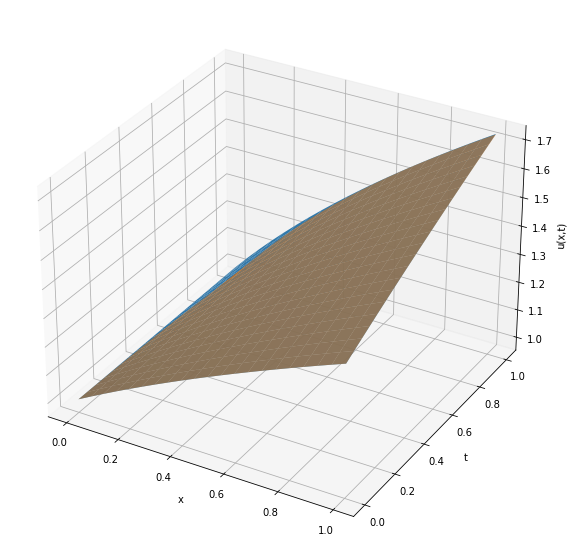

In [7]:
%matplotlib inline
def plot_u(X=X, T=T):
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(projection='3d')

  Xs, Ts = np.meshgrid(X, T)
  u = solver_h()

  ax.set_xlabel('x')
  ax.set_ylabel('t')
  ax.set_zlabel('u(x,t)')
  
  ax.plot_surface(Xs, Ts, solution(Xs, Ts), alpha=0.9, label="Real")
  ax.plot_surface(Xs, Ts, u, alpha=0.5, label="Calc")

plot_u()

In [8]:
Xs, Ts = np.meshgrid(X, T)

In [9]:
def solver_hh(X=X, T=T, h=h, dt=dt):
  uu = np.zeros(shape=(len(T), len(X))) 

  uu[0] = [ph1(x) for x in X]
  uu[1] = [ph1(x) + dt * ph2(x) + dt * dt / 2 * (aa * ph1d2(x) + f(x, 0)) for x in X]

  for n in range(1, len(T) - 1):
    for k in range(1, len(X) - 1):
      uu[n + 1][k] = aa * dt * dt / h / h * (uu[n][k+1] - 2  * uu[n][k] + uu[n][k-1]) + dt * dt * f(X[k], T[n]) + 2 * uu[n][k] - uu[n-1][k]
    uu[n+1][ 0] = (1 / (2 * h * B1 - 3 * A1)) * ( A1 * uu[n+1][ 2] - 4 * A1 * uu[n+1][ 1] + 2 * h * C1(T[n+1]))
    uu[n+1][-1] = (1 / (2 * h * B2 + 3 * A2)) * (-A2 * uu[n+1][-3] + 4 * A2 * uu[n+1][-2] + 2 * h * C2(T[n+1]))
  return uu

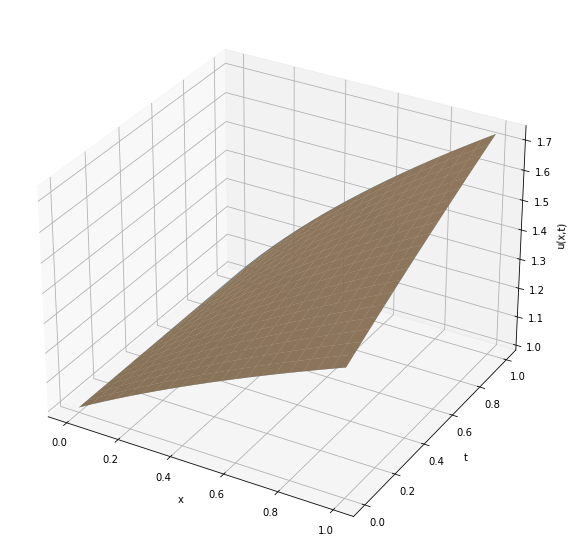

In [11]:
%matplotlib inline
def plot_u(X=X, T=T):
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(projection='3d')

  Xs, Ts = np.meshgrid(X, T)
  u = solver_hh()

  ax.set_xlabel('x')
  ax.set_ylabel('t')
  ax.set_zlabel('u(x,t)')
  
  ax.plot_surface(Xs, Ts, solution(Xs, Ts), alpha=0.9, label="Real")
  ax.plot_surface(Xs, Ts, u, alpha=0.5, label="Calc")

plot_u()

In [12]:
print(np.max(np.abs(solution(Xs, Ts) - solver_h())))
print(np.max(np.abs(solution(Xs, Ts) - solver_hh())))

0.03133659015028101
0.0019177964035290707
